# 0. IMPORT PACKAGES & DATASET

In [12]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', None)  # Show all rows
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

import optuna

In [13]:
df = pd.read_parquet("data/loan_final.parquet")

In [14]:
df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,policy_code,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,...,num_tl_90g_dpd_24m,num_accts_ever_120_pd,delinq_amnt,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,dti,dti_joint,revol_bal,revol_bal_joint,revol_util,total_rev_hi_lim,tot_coll_amt,tot_cur_bal,avg_cur_bal,all_util,max_bal_bc,il_util,bc_util,total_bal_il,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_hi_cred_lim,open_acc,total_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,num_actv_bc_tl,num_actv_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_il_tl,num_bc_tl,num_op_rev_tl,num_sats,num_bc_sats,total_cu_tl,bc_open_to_buy,percent_bc_gt_75,pct_tl_nvr_dlq
0,LOAN_1653274,MEM_931131,6000,6000,6000.0,36 months,8.39,189.10,A,A5,Oct-2014,Fully Paid,n,NaN,None,credit_card,Credit card refinancing,f,0.00,0.00,6804.781672,6804.78,6000.00,804.78,0.00,0.00,0.000,Oct-2017,189.08,None,1,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,...,1.0,1.0,0.0,NaN,NaN,NaN,18.98,NaN,6151,NaN,39.4,15600.0,0.0,41018.0,6836.0,NaN,NaN,NaN,45.2,NaN,41018.0,13600.0,40773.0,56373.0,6.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,90.0,86.0,17.0,13.0,1.0,1.0,8.0,1.0,11.0,6.0,5.0,6.0,4.0,NaN,7449.0,25.0,85.0
1,LOAN_812253,MEM_1111718,35000,35000,35000.0,60 months,20.99,946.68,E,E4,Oct-2014,Fully Paid,n,NaN,None,debt_consolidation,Debt consolidation,f,0.00,0.00,47656.460005,47656.46,35000.00,12656.46,0.00,0.00,0.000,Sep-2016,26829.50,None,1,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,...,0.0,2.0,0.0,NaN,NaN,NaN,11.27,NaN,4093,NaN,40.5,10100.0,59.0,153530.0,21933.0,NaN,NaN,NaN,NaN,NaN,49839.0,0.0,57417.0,186222.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,141.0,189.0,31.0,3.0,0.0,2.0,6.0,2.0,6.0,3.0,3.0,8.0,0.0,NaN,NaN,NaN,87.5
2,LOAN_2156025,MEM_545144,15000,15000,15000.0,36 months,7.49,466.53,A,A4,Apr-2017,Current,n,NaN,None,credit_card,Credit card refinancing,w,6235.37,6235.37,10286.280000,10286.28,8764.63,1521.65,0.00,0.00,0.000,Feb-2019,466.53,Mar-2019,1,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,...,0.0,0.0,0.0,NaN,NaN,NaN,19.09,NaN,34397,NaN,44.7,76900.0,0.0,88183.0,4409.0,63.0,15084.0,86.0,50.7,53786.0,88183.0,63000.0,62783.0,139683.0,21.0,29.0,0.0,4.0,2.0,4.0,1.0,2.0,6.0,128.0,298.0,10.0,7.0,7.0,12.0,22.0,12.0,6.0,14.0,17.0,21.0,10.0,0.0,31060.0,22.2,93.1
3,LOAN_1914224,MEM_196440,7000,7000,7000.0,36 months,10.99,229.14,B,B4,Oct-2016,Charged Off,n,NaN,None,debt_consolidation,Debt consolidation,w,0.00,0.00,2811.540000,2811.54,1380.75,677.24,15.00,738.55,132.939,Nov-2017,229.14,None,1,N,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,Cash,N,None,None,...,0.0,0.0,0.0,NaN,NaN,NaN,12.89,NaN,14258,NaN,75.4,18900.0,0.0,21285.0,3041.0,65.0,4224.0,50.0,83.5,7027.0,21285.0,6200.0,14000.0,32900.0,7.0,11.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,53.0,103.0,11.0,11.0,2.0,5.0,8.0,5.0,3.0,4.0,6.0,7.0,3.0,2.0,1020.0,33.3,100.0
4,LOAN_683879,MEM_968196,15600,15600,15600.0,36 months,12.69,523.30,C,C2,Jul-2015,Fully Paid,n,NaN,None,credit_card,Credit card refinancing,w,0.00,0.00,18760.971852,18760.97,15600.00,3160.97,0.00,0.00,0.000,Mar-2018,3072.97,N

In [15]:
# Drop columns due to possible data leakage or missing values (>60%) or noisy 
cols_to_drop = [
    'annual_inc_joint', 'verification_status_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
    'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'last_credit_pull_d', 'mths_since_last_record', 'mths_since_last_major_derog',
    'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 
    'dti_joint', 'revol_bal_joint', 'url', 'desc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
    'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'policy_code', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 
    'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status',
    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 
    'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'next_pymnt_d', 'issue_d', 'loan_status', 'title', 'emp_title', 'addr_state', 
    'zip_code', 'earliest_cr_line'
]
df = df.drop(columns=cols_to_drop)
print(df.shape)
df.head()

(2260668, 84)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,pymnt_plan,purpose,initial_list_status,disbursement_method,debt_settlement_flag,snapshot_date,emp_length,home_ownership,annual_inc,verification_status,application_type,mort_acc,num_tl_op_past_12m,inq_last_6mths,inq_last_12m,inq_fi,mths_since_last_delinq,mths_since_recent_inq,mths_since_rcnt_il,mths_since_recent_bc,acc_now_delinq,delinq_2yrs,pub_rec,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens,pub_rec_bankruptcies,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_accts_ever_120_pd,delinq_amnt,dti,revol_bal,revol_util,total_rev_hi_lim,tot_coll_amt,tot_cur_bal,avg_cur_bal,all_util,max_bal_bc,il_util,bc_util,total_bal_il,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_hi_cred_lim,open_acc,total_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,num_actv_bc_tl,num_actv_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_il_tl,num_bc_tl,num_op_rev_tl,num_sats,num_bc_sats,total_cu_tl,bc_open_to_buy,percent_bc_gt_75,pct_tl_nvr_dlq
0,LOAN_1653274,MEM_931131,6000,6000,6000.0,36 months,8.39,189.10,A,A5,n,credit_card,f,Cash,N,2022-01-01,< 1 year,RENT,48000.0,Not Verified,Individual,0.0,0.0,0.0,NaN,NaN,19.0,13.0,NaN,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,18.98,6151,39.4,15600.0,0.0,41018.0,6836.0,NaN,NaN,NaN,45.2,NaN,41018.0,13600.0,40773.0,56373.0,6.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,90.0,86.0,17.0,13.0,1.0,1.0,8.0,1.0,11.0,6.0,5.0,6.0,4.0,NaN,7449.0,25.0,85.0
1,LOAN_812253,MEM_1111718,35000,35000,35000.0,60 months,20.99,946.68,E,E4,n,debt_consolidation,f,Cash,N,2022-01-01,< 1 year,MORTGAGE,110000.0,Verified,Individual,3.0,1.0,1.0,NaN,NaN,67.0,3.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11.27,4093,40.5,10100.0,59.0,153530.0,21933.0,NaN,NaN,NaN,NaN,NaN,49839.0,0.0,57417.0,186222.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,141.0,189.0,31.0,3.0,0.0,2.0,6.0,2.0,6.0,3.0,3.0,8.0,0.0,NaN,NaN,NaN,87.5
2,LOAN_2156025,MEM_545144,15000,15000,15000.0,36 months,7.49,466.53,A,A4,n,credit_card,w,Cash,N,2022-01-01,2 years,RENT,95000.0,Not Verified,Individual,1.0,3.0,0.0,2.0,0.0,7.0,10.0,7.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.09,34397,44.7,76900.0,0.0,88183.0,4409.0,63.0,15084.0,86.0,50.7,53786.0,88183.0,63000.0,62783.0,139683.0,21.0,29.0,0.0,4.0,2.0,4.0,1.0,2.0,6.0,128.0,298.0,10.0,7.0,7.0,12.0,22.0,12.0,6.0,14.0,17.0,21.0,10.0,0.0,31060.0,22.2,93.1
3,LOAN_1914224,MEM_196440,7000,7000,7000.0,36 months,10.99,229.14,B,B4,n,debt_consolidation,w,Cash,N,2022-01-01,1 year,RENT,80000.0,Source Verified,Individual,0.0,1.0,1.0,3.0,0.0,NaN,1.0,40.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.89,14258,75.4,18900.0,0.0,21285.0,3041.0,65.0,4224.0,50.0,83.5,7027.0,21285.0,6200.0,14000.0,32900.0,7.0,11.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,53.0,103.0,11.0,11.0,2.0,5.0,8.0,5.0,3.0,4.0,6.0,7.0,3.0,2.0,1020.0,33.3,100.0
4,LOAN_683879,MEM_968196,15600,15600,15600.0,36 months,12.69,523.30,C,C2,n,credit_card,w,Cash,N,2022-01-01,4 years,RENT,50000.0,Not Verified,Individual,0.0,6.0,0.0,NaN,NaN,NaN,12.0,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.02,19643,77.0,25500.0,0.0,31290.0,2235.0,NaN,NaN,NaN,95.1,NaN,31290.0,17500.0,26208.0,51708.0,15.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,52.0,90.0,10.0,8.0,5.0,8.0,12.0,8.0,10.0,6.0,12.0,15.0,6.0,NaN,856.0,80.0,100.0


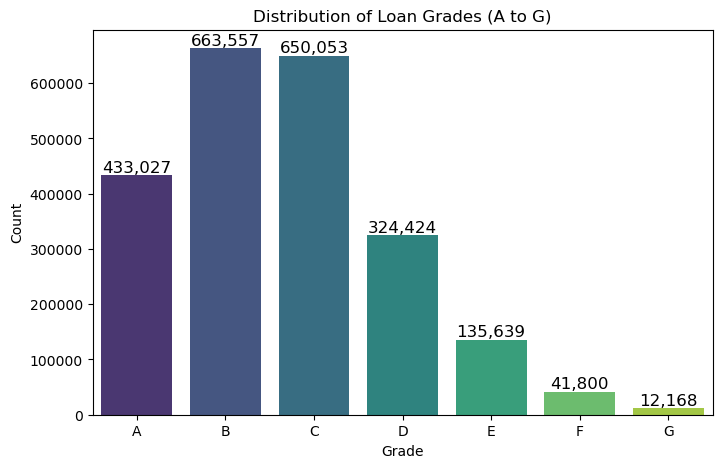

In [16]:
grade_counts = df['grade'].value_counts(dropna=False).sort_index().reset_index()
grade_counts
grade_counts.columns=['grade', 'count']
plt.figure(figsize=(8,5))
ax = sns.barplot(data=grade_counts, x='grade', y='count', palette='viridis', hue='grade')
# Add counts on top of bars
for i, row in grade_counts.iterrows():
    ax.text(i, row['count'], f"{row['count']:,}", ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Loan Grades (A to G)')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

# 1. SPLIT DATA

In [17]:
# Sort by date column 
df = df.sort_values('snapshot_date')

# Define cutoff dates to split into train/val/test 
# Train/val/test: 2022-01-01 to 2024-03-31
# OOT1: 2024-04-01 to 2024-06-30
# OOT2: 2024-07-01 to 2024-09-30
# OOT3: 2024-10-01 to 2024-12-31

oot3 = df[(df['snapshot_date'] >= '2024-10-01') & (df['snapshot_date'] <= '2024-12-31')]
oot2 = df[(df['snapshot_date'] >= '2024-07-01') & (df['snapshot_date'] <= '2024-09-30')]
oot1 = df[(df['snapshot_date'] >= '2024-04-01') & (df['snapshot_date'] <= '2024-06-30')]
train_val_test = df[df['snapshot_date'] < '2024-04-01']


In [18]:
def drop_columns(df):
    df_x = df.drop(columns=['id', 'member_id', 'grade', 'sub_grade', 'snapshot_date'])
    df_y = df['grade']
    return df_x, df_y 

X = train_val_test.drop(columns=['id', 'member_id', 'grade', 'sub_grade', 'snapshot_date'])
y = train_val_test['grade']

oot1_x, oot1_y = drop_columns(oot1)
oot2_x, oot2_y = drop_columns(oot2)
oot3_x, oot3_y = drop_columns(oot3)

print(X.shape, y.shape, oot1_x.shape, oot1_y.shape, oot2_x.shape, oot2_y.shape, oot3_x.shape, oot3_y.shape)

(1693876, 79) (1693876,) (187759, 79) (187759,) (189657, 79) (189657,) (189376, 79) (189376,)


In [19]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, stratify=y_, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1185713, 79) (1185713,) (254081, 79) (254081,) (254082, 79) (254082,)


# 2. DATA CLEANING & PREPROCESSING

## 2.1 Demographic Features

In [20]:
def clean_demographic_features(df): 
    df['home_ownership'] = df['home_ownership'].fillna('MISSING')
    df['annual_inc'] = df['annual_inc'].fillna(-1)
    df['emp_length'] = df['emp_length'].fillna('MISSING')

    emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    'MISSING': -1  # or use np.nan if you plan to impute
    }
    df['emp_length'] = df['emp_length'].map(emp_length_map)

    df['application_type'] = df['application_type'].map({'Individual': 0, 'Joint App': 1})


    return df 

# X_train = clean_demographic_features(X_train)

## 2.2 Credit History Features

In [21]:
def clean_credit_history_features(df):
    # Fill NA with -1. 
    cols = [
        'mort_acc', 'num_tl_op_past_12m', 'inq_last_12m', 'inq_fi', 'mths_since_last_delinq',
        'mths_since_recent_inq', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'num_tl_120dpd_2m',
        'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_accts_ever_120_pd'
    ]
    df = df.fillna({col: -1 for col in cols})

    # Impute missing values with the mode. 
    cols = [
        'inq_last_6mths', 'acc_now_delinq', 'delinq_2yrs', 'pub_rec', 
        'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens', 'pub_rec_bankruptcies',
        'delinq_amnt'
    ]

    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    return df

# X_train = clean_credit_history_features(X_train)

## 2.3 Financial Features

In [22]:
def clean_financial_features(df):
    # Impute with mean 
    df['dti'] = df['dti'].fillna(df['dti'].mean())
    
    # Impute with 0
    cols = [
        "revol_util", "total_rev_hi_lim", "tot_coll_amt", "tot_cur_bal", "avg_cur_bal", "all_util", "max_bal_bc", 
        "open_acc", "total_acc", "open_acc_6m", "open_act_il", "open_il_12m", "open_il_24m", "open_rv_12m", "open_rv_24m", 
        "acc_open_past_24mths", "num_actv_bc_tl", "num_actv_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0", "num_il_tl", 
        "num_bc_tl", "num_op_rev_tl", "num_sats", "num_bc_sats", "total_cu_tl"
    ]
    df[cols] = df[cols].fillna(0)

    # Impute it with -1 
    cols = [
        "il_util", "bc_util", "total_bal_il", "total_bal_ex_mort", "total_bc_limit", "total_il_high_credit_limit", 
        "tot_hi_cred_lim", "mo_sin_old_il_acct", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", 
        "bc_open_to_buy", "percent_bc_gt_75", "pct_tl_nvr_dlq"
    ]
    df = df.fillna({col: -1 for col in cols})

    return df

# X_train = clean_financial_features(X_train)

## 2.4 Loan Terms & Payment Info Features

In [23]:
def clean_loan_terms_and_payment_info_features(df):
    # Convert string values to 0/1 
    binary_cols = ['pymnt_plan', 'debt_settlement_flag', 'initial_list_status', 'disbursement_method']
    df[binary_cols] = df[binary_cols].apply(lambda col: col.str.lower().map({'y': 1, 'n': 0, 'w': 1, 'f': 0, 'cash': 1, 'directpay': 0}))

    # Extract only the months
    df['term'] = df['term'].str.extract(r'(\d+)').astype(int)

    return df

# X_train = clean_loan_terms_and_payment_info_features(X_train)

In [24]:
# # Sanity check for missing values 
# for col in X_train:
#     print(col)
#     print(X_train[col].isna().sum())

## 2.5 Clean & Preprocess X_train, X_val, X_test separately

In [25]:
X_train = clean_demographic_features(X_train)
X_train = clean_credit_history_features(X_train)
X_train = clean_financial_features(X_train)
X_train = clean_loan_terms_and_payment_info_features(X_train)

X_val = clean_demographic_features(X_val)
X_val = clean_credit_history_features(X_val)
X_val = clean_financial_features(X_val)
X_val = clean_loan_terms_and_payment_info_features(X_val)

X_test = clean_demographic_features(X_test)
X_test = clean_credit_history_features(X_test)
X_test = clean_financial_features(X_test)
X_test = clean_loan_terms_and_payment_info_features(X_test)

oot1_x = clean_demographic_features(oot1_x)
oot1_x = clean_credit_history_features(oot1_x)
oot1_x = clean_financial_features(oot1_x)
oot1_x = clean_loan_terms_and_payment_info_features(oot1_x)

oot2_x = clean_demographic_features(oot2_x)
oot2_x = clean_credit_history_features(oot2_x)
oot2_x = clean_financial_features(oot2_x)
oot2_x = clean_loan_terms_and_payment_info_features(oot2_x)

oot3_x = clean_demographic_features(oot3_x)
oot3_x = clean_credit_history_features(oot3_x)
oot3_x = clean_financial_features(oot3_x)
oot3_x = clean_loan_terms_and_payment_info_features(oot3_x)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
print(oot1_x.shape, oot1_y.shape, oot2_x.shape, oot2_y.shape, oot3_x.shape, oot3_y.shape)

(1185713, 79) (1185713,) (254081, 79) (254081,) (254082, 79) (254082,)
(187759, 79) (187759,) (189657, 79) (189657,) (189376, 79) (189376,)


# 3. EXTRA PREPROCESSING FOR NEURAL NETWORK

## 3.1 Standard Scaling

In [26]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,pymnt_plan,purpose,initial_list_status,disbursement_method,debt_settlement_flag,emp_length,home_ownership,annual_inc,verification_status,application_type,mort_acc,num_tl_op_past_12m,inq_last_6mths,inq_last_12m,inq_fi,mths_since_last_delinq,mths_since_recent_inq,mths_since_rcnt_il,mths_since_recent_bc,acc_now_delinq,delinq_2yrs,pub_rec,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens,pub_rec_bankruptcies,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_accts_ever_120_pd,delinq_amnt,dti,revol_bal,revol_util,total_rev_hi_lim,tot_coll_amt,tot_cur_bal,avg_cur_bal,all_util,max_bal_bc,il_util,bc_util,total_bal_il,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_hi_cred_lim,open_acc,total_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,num_actv_bc_tl,num_actv_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_il_tl,num_bc_tl,num_op_rev_tl,num_sats,num_bc_sats,total_cu_tl,bc_open_to_buy,percent_bc_gt_75,pct_tl_nvr_dlq
698250,7000,7000,7000.0,36,8.81,221.98,0,debt_consolidation,1,1,0,9,RENT,82000.0,Not Verified,0,0.0,2.0,0.0,1.0,1.0,-1.0,11.0,11.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.34,4989,24.1,20700.0,0.0,8854.0,984.0,33.0,1316.0,60.0,21.5,3865.0,8854.0,9300.0,6400.0,27100.0,9.0,14.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,38.0,68.0,6.0,6.0,2.0,6.0,12.0,6.0,2.0,4.0,8.0,9.0,4.0,2.0,7296.0,0.0,100.0
179253,28800,28800,28775.0,60,17.47,723.06,0,debt_consolidation,0,1,0,2,OWN,65000.0,Verified,0,1.0,3.0,1.0,2.0,1.0,-1.0,6.0,88.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.77,9590,87.2,11000.0,0.0,92739.0,30913.0,87.0,122.0,-1.0,12.2,0.0,9590.0,1000.0,0.0,95452.0,3.0,6.0,1.0,0.0,0.0,0.0,3.0,3.0,4.0,162.0,10.0,6.0,6.0,1.0,2.0,3.0,2.0,2.0,1.0,2.0,3.0,1.0,1.0,878.0,0.0,100.0
234227,28000,28000,28000.0,36,14.99,970.50,0,debt_consolidation,0,1,0,10,RENT,130000.0,Source Verified,0,0.0,1.0,0.0,1.0,1.0,68.0,10.0,3.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.43,24063,79.2,30400.0,0.0,43106.0,4311.0,85.0,2299.0,94.0,78.7,19043.0,43106.0,9900.0,20163.0,50563.0,10.0,20.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,134.0,153.0,38.0,3.0,5.0,9.0,14.0,9.0,6.0,7.0,9.0,10.0,5.0,0.0,2111.0,80.0,90.0
511455,12000,12000,12000.0,60,12.49,269.92,0,credit_card,1,1,0,7,RENT,72000.0,Source Verified,0,0.0,2.0,0.0,-1.0,-1.0,18.0,10.0,-1.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.77,9725,36.8,26400.0,0.0,51567.0,4297.0,0.0,0.0,-1.0,44.1,-1.0,51567.0,19100.0,51604.0,78004.0,12.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,78.0,96.0,10.0,10.0,3.0,5.0,21.0,5.0,5.0,7.0,10.0,12.0,4.0,0.0,10669.0,25.0,96.2
746298,4500,4500,4500.0,36,19.52,166.14,0,credit_card,0,1,0,10,RENT,97000.0,Source Verified,0,0.0,5.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.27,6722,78.2,8600.0,0.0,104940.0,4770.0,0.0,0.0,-1.0,75.8,-1.0,104940.0,5000.0,101461.0,110061.0,22.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,119.0,151.0,1.0,1.0,4.0,6.0,10.0,6.0,21.0,7.0,7.0,22.0,5.0,0.0,1209.0,60.0,100.0


In [27]:
# Standard Scaling 
# [
#     'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length',
#     'annual_inc', 'mort_acc', 'num_tl_op_past_12m', 'inq_last_6mths', 'inq_last_12m', 'inq_fi',
#     'mths_since_last_delinq', 'mths_since_recent_inq', 'mths_since_rcnt_il', 'mths_since_recent_bc',
#     'acc_now_delinq', 'delinq_2yrs', 'pub_rec', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths',
#     'tax_liens', 'pub_rec_bankruptcies', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 
#     'num_accts_ever_120_pd', 'delinq_amnt', 'dti', 'revol_bal', 'revol_util', 'total_rev_hi_lim', 'tot_coll_amt',
#     'tot_cur_bal', 'avg_cur_bal', 'all_util', 'max_bal_bc', 'il_util', 'bc_util', 'total_bal_il', 'total_bal_ex_mort',
#     'total_bc_limit', 'total_il_high_credit_limit', 'tot_hi_cred_lim', 'open_acc', 'total_acc', 'open_acc_6m',
#     'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'acc_open_past_24mths', 'mo_sin_old_il_acct',
#     'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_rev_accts', 
#     'num_rev_tl_bal_gt_0', 'num_il_tl', 'num_bc_tl', 'num_op_rev_tl', 'num_sats', 'num_bc_sats', 'total_cu_tl', 'bc_open_to_buy', 
#     'percent_bc_gt_75', 'pct_tl_nvr_dlq'
# ]

# One-hot encoding
# purpose, home_ownership, verification_status, 

# Binary 
# pymnt_plan, initial_list_status, disbursement_method, debt_settlement_flag, application_type

# X_train.open_rv_24m.value_counts(dropna=False)
# X_train.loan_status.info()

In [28]:
# Standard Scaling Function 

def scale_features(train_df, *other_dfs, numeric_cols): 
    scaler = StandardScaler()
    train_scaled = train_df.copy()

    train_scaled[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

    scaled_others = []
    for df in other_dfs: 
        df_scaled = df.copy()
        df_scaled[numeric_cols] = scaler.transform(df[numeric_cols])
        scaled_others.append(df_scaled)

    return (train_scaled, *scaled_others, scaler)

numeric_cols = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length',
    'annual_inc', 'mort_acc', 'num_tl_op_past_12m', 'inq_last_6mths', 'inq_last_12m', 'inq_fi',
    'mths_since_last_delinq', 'mths_since_recent_inq', 'mths_since_rcnt_il', 'mths_since_recent_bc',
    'acc_now_delinq', 'delinq_2yrs', 'pub_rec', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths',
    'tax_liens', 'pub_rec_bankruptcies', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 
    'num_accts_ever_120_pd', 'delinq_amnt', 'dti', 'revol_bal', 'revol_util', 'total_rev_hi_lim', 'tot_coll_amt',
    'tot_cur_bal', 'avg_cur_bal', 'all_util', 'max_bal_bc', 'il_util', 'bc_util', 'total_bal_il', 'total_bal_ex_mort',
    'total_bc_limit', 'total_il_high_credit_limit', 'tot_hi_cred_lim', 'open_acc', 'total_acc', 'open_acc_6m',
    'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'acc_open_past_24mths', 'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_rev_accts', 
    'num_rev_tl_bal_gt_0', 'num_il_tl', 'num_bc_tl', 'num_op_rev_tl', 'num_sats', 'num_bc_sats', 'total_cu_tl', 'bc_open_to_buy', 
    'percent_bc_gt_75', 'pct_tl_nvr_dlq'
]

X_train_scaled, X_val_scaled, X_test_scaled, oot1_x_scaled, oot2_x_scaled, oot3_x_scaled, scaler = scale_features(X_train, X_val, X_test, oot1_x, oot2_x, oot3_x, numeric_cols=numeric_cols)

## 3.2 One-Hot Encoding

In [29]:
# One-Hot Encoding Function 

def one_hot_encode(train_df, *other_dfs, categorical_cols): 
    # One-hot encode train 
    train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)

    # Use train columns as reference 
    other_encoded = []
    for df in other_dfs:
        encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
        aligned = encoded.reindex(columns=train_encoded.columns, fill_value=0)
        other_encoded.append(aligned)

    return (train_encoded, *other_encoded)

categorical_cols = [
    'purpose', 'home_ownership', 'verification_status',
]

X_train_scaled_encoded, X_val_scaled_encoded, X_test_scaled_encoded, oot1_x_scaled_encoded, oot2_x_scaled_encoded, oot3_x_scaled_encoded = one_hot_encode(
    X_train_scaled, X_val_scaled, X_test_scaled, 
    oot1_x_scaled, oot2_x_scaled, oot3_x_scaled, 
    categorical_cols=categorical_cols
    )

In [30]:
X_train_scaled_encoded.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,pymnt_plan,initial_list_status,disbursement_method,debt_settlement_flag,emp_length,annual_inc,application_type,mort_acc,num_tl_op_past_12m,inq_last_6mths,inq_last_12m,inq_fi,mths_since_last_delinq,mths_since_recent_inq,mths_since_rcnt_il,mths_since_recent_bc,acc_now_delinq,delinq_2yrs,pub_rec,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens,pub_rec_bankruptcies,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_accts_ever_120_pd,delinq_amnt,dti,revol_bal,revol_util,total_rev_hi_lim,tot_coll_amt,tot_cur_bal,avg_cur_bal,all_util,max_bal_bc,il_util,bc_util,total_bal_il,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_hi_cred_lim,open_acc,total_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,acc_open_past_24mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,num_actv_bc_tl,num_actv_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_il_tl,num_bc_tl,num_op_rev_tl,num_sats,num_bc_sats,total_cu_tl,bc_open_to_buy,percent_bc_gt_75,pct_tl_nvr_dlq,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
698250,-0.875409,-0.874993,-0.872651,-0.636316,-0.886192,-0.837780,0,1,1,0,0.883450,0.051062,0,-0.781218,0.008794,-0.649777,0.052615,0.494709,-0.739460,0.811643,-0.054828,-0.562121,-0.058305,-0.353864,-0.348429,-0.120483,-0.080333,-0.125762,-0.351599,0.26574,0.15436,-0.095314,-0.335909,-0.017764,-0.889816,-0.515852,-1.058821,-0.356910,-0.027604,-0.808956,-0.744176,-0.068652,-0.409214,0.613357,-1.147090,-0.466487,-0.825845,-0.580370,-0.799763,-0.805687,-0.464196,-0.848270,0.423070,-0.264066,0.729244,0.023629,0.151866,-0.286042,-0.757905,-1.332588,-1.072415,-0.433212,-0.218694,-0.658398,0.156843,-0.190117,0.175765,-0.833002,-0.724179,0.001212,-0.398224,-0.210983,0.487061,-0.226295,-1.123752,0.471389,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
179253,1.496832,1.497722,1.496359,1.571546,0.906939,1.039243,0,0,1,0,-0.873679,-0.165384,0,-0.260311,0.539290,0.476657,0.471671,0.494709,-0.739460,0.003085,3.325543,-0.562121,-0.058305,-0.353864,-0.348429,-0.120483,-0.080333,-0.125762,-0.351599,0.26574,0.15436,-0.095314,-0.335909,-0.017764,-1.144356,-0.312751,1.491679,-0.627007,-0.027604,-0.284024,1.090352,1.605923,-0.624308,-0.947572,-1.456769,-0.566347,-0.811046,-0.940119,-0.942045,-0.427611,-1.528588,-1.515625,0.423070,-0.631210,-0.522912,-0.663546,1.641740,0.533144,-0.133272,0.733438,-1.648545,-0.433212,-0.218694,-1.079547,-0.997464,-1.278210,-1.008780,-0.833002,-1.347035,-1.242345,-1.421617,-1.181244,0.038818,-0.617262,-1.123752,0.471389,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
234227,1.409777,1.410650,1.412043,-0.636316,0.393433,1.966143,0,0,1,0,1.134469,0.662204,0,-0.781218,-0.521703,-0.649777,0.052615,0.494709,2.203372,0.649931,-0.406035,0.436275,-0.058305,-0.353864,-0.348429,-0.120483,-0.080333,-0.125762,-0.351599,0.26574,0.15436,-0.095314,-0.335909,-0.017764,-0.384302,0.326129,1.168319,-0.086813,-0.027604,-0.594615,-0.540244,1.543902,-0.232131,1.483383,0.757606,-0.074332,-0.137135,-0.554364,-0.493791,-0.675906,-0.286798,-0.347754,0.423070,-0.264066,0.729244,0.023629,-0.593071,-0.695635,-1.070221,0.266916,-0.228086,1.400668,-0.545034,0.605048,1.022574,0.051681,1.064174,-0.292243,-0.101322,0.208471,-0.227659,0.112438,-0.409425,-0.542151,1.069481,-0.063215,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
511455,-0.331317,-0.3307

## 3.3 Label Encoding: Target Variable - 'Grade'

In [31]:
# Label encoded target variable for y_train, y_val, y_test 
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)
oot1_y_encoded = le.transform(oot1_y)
oot2_y_encoded = le.transform(oot2_y)
oot3_y_encoded = le.transform(oot3_y)

## 3.4 Sanity Check before Modelling

In [32]:
# Sanity check 
print(f"""
    X_train: {X_train_scaled_encoded.shape}, {y_train_encoded.shape},
    X_val: {X_val_scaled_encoded.shape}, {y_val_encoded.shape},
    X_test: {X_test_scaled_encoded.shape}, {y_test_encoded.shape},
    OOT1: {oot1_x_scaled_encoded.shape}, {oot1_y_encoded.shape},
    OOT2: {oot2_x_scaled_encoded.shape}, {oot2_y_encoded.shape},
    OOT3: {oot3_x_scaled_encoded.shape}, {oot3_y_encoded.shape}
    """
    )


    X_train: (1185713, 96), (1185713,),
    X_val: (254081, 96), (254081,),
    X_test: (254082, 96), (254082,),
    OOT1: (187759, 96), (187759,),
    OOT2: (189657, 96), (189657,),
    OOT3: (189376, 96), (189376,)
    


# 4. Modelling (ANN)

In [33]:
# List of dfs 
dfs_x= X_train_scaled_encoded, X_val_scaled_encoded, X_test_scaled_encoded, oot1_x_scaled_encoded, oot2_x_scaled_encoded, oot3_x_scaled_encoded

# Convert all features to numeric types 
def convert_to_numeric(*dfs):
    converted = [df.astype('float32') for df in dfs]
    return tuple(converted) 

X_train_converted, X_val_converted, X_test_converted, oot1_x_converted, oot2_x_converted, oot3_x_converted = convert_to_numeric(*dfs_x)

######
dfs_numeric = X_train_converted, X_val_converted, X_test_converted, oot1_x_converted, oot2_x_converted, oot3_x_converted
ys = y_train_encoded, y_val_encoded, y_test_encoded, oot1_y_encoded, oot2_y_encoded, oot3_y_encoded

# Convert X to tensors 
def convert_to_tensors_for_X(*dfs):
    converted = [torch.tensor(df.values, dtype=torch.float32) for df in dfs]
    return tuple(converted)

# Convert y to tensors
def convert_to_tensors_for_y(*ys):
    converted = [torch.tensor(y, dtype=torch.long) for y in ys]
    return tuple(converted)

X_train_tensor, X_val_tensor, X_test_tensor, oot1_x_tensor, oot2_x_tensor, oot3_x_tensor = convert_to_tensors_for_X(*dfs_numeric)
y_train_tensor, y_val_tensor, y_test_tensor, oot1_y_tensor, oot2_y_tensor, oot3_y_tensor = convert_to_tensors_for_y(*ys)

###### 
# Create DataLoaders 
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
oot1_ds = TensorDataset(oot1_x_tensor, oot1_y_tensor)
oot2_ds = TensorDataset(oot2_x_tensor, oot2_y_tensor)
oot3_ds = TensorDataset(oot3_x_tensor, oot3_y_tensor)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False) # Set to false for deterministic evaluation
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)
oot1_loader = DataLoader(oot1_ds, batch_size=128, shuffle=False)
oot2_loader = DataLoader(oot2_ds, batch_size=128, shuffle=False)
oot3_loader = DataLoader(oot3_ds, batch_size=128, shuffle=False)


## 4.1 Baseline ANN

In [34]:
# # 2 hidden layers (tried)
# # Define the model
# class GradeClassifier(nn.Module):
#     def __init__(self, input_dim=96, output_dim=7):
#         super(GradeClassifier, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.3),
#             nn.Linear(128,64),
#             nn.ReLU(),
#             nn.BatchNorm1d(64),
#             nn.Dropout(0.3),
#             nn.Linear(64, output_dim)
#         )
    
#     def forward(self, x):
#         return self.model(x)
    
# # 4 hidden layers
# # Define the model
# class GradeClassifier(nn.Module):
#     def __init__(self, input_dim=96, output_dim=7):
#         super(GradeClassifier, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.GELU(),
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.2),

#             nn.Linear(512,256),
#             nn.GELU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.2),

#             nn.Linear(256,128),
#             nn.GELU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.2),

#             nn.Linear(128,64),
#             nn.GELU(),
#             nn.BatchNorm1d(64),
#             nn.Dropout(0.2),
            
#             nn.Linear(64, output_dim)
#         )
    
#     def forward(self, x):
#         return self.model(x)

# # 4 hidden layers (Increased neurons)
# # Define the model
# class GradeClassifier(nn.Module):
#     def __init__(self, input_dim=96, output_dim=7):
#         super(GradeClassifier, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 1024),
#             nn.GELU(),
#             nn.BatchNorm1d(1024),
#             nn.Dropout(0.2),

#             nn.Linear(1024,512),
#             nn.GELU(),
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.2),

#             nn.Linear(512,256),
#             nn.GELU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.2),

#             nn.Linear(256,128),
#             nn.GELU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.2),
            
#             nn.Linear(128, output_dim)
#         )

# 4 hidden layers (dropout=0.1)
# Define the model
class GradeClassifier(nn.Module):
    def __init__(self, input_dim=96, output_dim=7):
        super(GradeClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),

            nn.Linear(512,256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),

            nn.Linear(256,128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),

            nn.Linear(128,64),
            nn.GELU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

    def forward(self, x):
        return self.model(x)

In [35]:
# # Use class weights 
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_encoded),
#     y=y_train_encoded
# )

# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# class_weights_tensor

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Instantiate model, loss, optimizer 
model = GradeClassifier(input_dim=96, output_dim=7).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cuda


In [37]:
# Training loop with validation set 

num_epochs = 30
best_val_f1 = 0
best_model_state = None 

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_targets = []

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(preds.argmax(dim=1).detach().cpu().tolist())
        train_targets.extend(yb.cpu().tolist())

    train_f1 = f1_score(train_targets, train_preds, average='macro')

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            val_preds.extend(preds.argmax(dim=1).cpu().tolist())
            val_targets.extend(yb.cpu().tolist())
    
    val_f1 = f1_score(val_targets, val_preds, average='macro')

    # Save best model 
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()
        best_epoch = epoch+1
        print(f"New best model found at epoch {best_epoch} with Val F1: {val_f1:.4f}")

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Train F1 = {train_f1:.4f} | Val Loss = {val_loss:.4f} | Val F1 = {val_f1:.4f}")

New best model found at epoch 1 with Val F1: 0.6819
Epoch 1: Train Loss = 3593.3640 | Train F1 = 0.6665 | Val Loss = 599.9528 | Val F1 = 0.6819
New best model found at epoch 2 with Val F1: 0.7374
Epoch 2: Train Loss = 3022.7437 | Train F1 = 0.7043 | Val Loss = 581.2938 | Val F1 = 0.7374
New best model found at epoch 3 with Val F1: 0.7579
Epoch 3: Train Loss = 2864.3116 | Train F1 = 0.7183 | Val Loss = 557.8768 | Val F1 = 0.7579
Epoch 4: Train Loss = 2774.9284 | Train F1 = 0.7248 | Val Loss = 547.4406 | Val F1 = 0.7316
Epoch 5: Train Loss = 2703.2994 | Train F1 = 0.7297 | Val Loss = 543.0717 | Val F1 = 0.7512
Epoch 6: Train Loss = 2627.3213 | Train F1 = 0.7360 | Val Loss = 515.9732 | Val F1 = 0.7516
Epoch 7: Train Loss = 2563.7304 | Train F1 = 0.7410 | Val Loss = 508.1959 | Val F1 = 0.7320
Epoch 8: Train Loss = 2524.7198 | Train F1 = 0.7455 | Val Loss = 500.4902 | Val F1 = 0.7378
Epoch 9: Train Loss = 2485.2244 | Train F1 = 0.7464 | Val Loss = 491.3896 | Val F1 = 0.7349
New best model f

In [ ]:
# Base: 2 hidden layers 
# Epoch 10: Train Loss = 2715.8144 | Train F1 = 0.7154 | Val Loss = 524.5816 | Val F1 = 0.7564
# With class weights:
# Epoch 20: Train Loss = 4703.8999 | Train F1 = 0.7205 | Val Loss = 904.6257 | Val F1 = 0.7527

# Base: 3 hidden layers 
# Epoch 19: Train Loss = 2622.9141 | Train F1 = 0.7198 | Val Loss = 506.5785 | Val F1 = 0.7601

# Base: 4 hidden layers 
# Epoch 14: Train Loss = 2391.4479 | Train F1 = 0.7481 | Val Loss = 469.5309 | Val F1 = 0.7912

# Base: 4 hidden layers (dropout=0.1)
# Epoch 24: Train Loss = 2211.6425 | Train F1 = 0.7681 | Val Loss = 445.6734 | Val F1 = 0.8013

In [38]:
# Prediction Function
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)  # shape: [batch_size, num_classes]
            probs = torch.softmax(outputs, dim=1)  # probabilities
            preds = torch.argmax(probs, dim=1)     # predicted class labels
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    return torch.cat(all_preds), torch.cat(all_probs)

In [39]:
model = GradeClassifier(input_dim=96, output_dim=7).to(device) # Recreate model architecture
model.load_state_dict(best_model_state) # Load the saved weights 
model.eval()

test_preds, test_probs = predict(model, test_loader, device)
oot1_preds, oot1_probs = predict(model, oot1_loader, device)
oot2_preds, oot2_probs = predict(model, oot2_loader, device)
oot3_preds, oot3_probs = predict(model, oot3_loader, device)

# Convert ground truths and predictions to NumPy
test_true, test_pred = y_test_tensor.numpy(), test_preds.numpy()
oot1_true, oot1_pred = oot1_y_tensor.numpy(), oot1_preds.numpy()
oot2_true, oot2_pred = oot2_y_tensor.numpy(), oot2_preds.numpy()
oot3_true, oot3_pred = oot3_y_tensor.numpy(), oot3_preds.numpy()

# Cmopute and print Macro F1 scores
test_f1 = f1_score(test_true, test_pred, average='macro')
oot1_f1 = f1_score(oot1_true, oot1_pred, average='macro')
oot2_f1 = f1_score(oot2_true, oot2_pred, average='macro')
oot3_f1 = f1_score(oot3_true, oot3_pred, average='macro')


print(f"Test F1: {test_f1:.4f}")
print(f"OOT1 F1: {oot1_f1:.4f}")
print(f"OOT2 F1: {oot2_f1:.4f}")
print(f"OOT3 F1: {oot3_f1:.4f}")

Test F1: 0.7677
OOT1 F1: 0.7328
OOT2 F1: 0.7257
OOT3 F1: 0.7215


In [40]:
# Baseline ANN 
# Epoch 10: Train Loss = 2715.8144 | Train F1 = 0.7154 | Val Loss = 524.5816 | Val F1 = 0.7564
# Test F1: 0.7142, OOT1 F1: 0.6945, OOT2 F1: 0.6924, OOT3 F1: 0.6855

# Base: 4 hidden layers (dropout=0.1)
# Epoch 24: Train Loss = 2211.6425 | Train F1 = 0.7681 | Val Loss = 445.6734 | Val F1 = 0.8013
# Test F1: 0.7723, OOT1, F1: 0.7343, OOT2 F1: 0.7320, OOT3 F1: 0.7282

In [43]:
# Save the best model 
torch.save(best_model_state, 'models/ann_best_model_state.pth')

## 4.2 Tuned ANN

In [81]:
# Define Optuna Objective Function 

def objective(trial):
    # Suggested hyperparams
    hidden1 = trial.suggest_int("hidden1", 128, 512)
    hidden2 = trial.suggest_int("hidden2", 64, 256)
    dropout = trial.suggest_float("dropout", 0.1, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    activation_name = trial.suggest_categorical("activation", ["relu", "gelu"])

    act_fn = nn.ReLU() if activation_name == "relu" else nn.GELU()

    # Model definition
    class TunedNet(nn.Module):
        def __init__(self, input_dim=96, output_dim=7):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden1),
                act_fn,
                nn.BatchNorm1d(hidden1),
                nn.Dropout(dropout),
                nn.Linear(hidden1, hidden2),
                act_fn,
                nn.BatchNorm1d(hidden2),
                nn.Dropout(dropout),
                nn.Linear(hidden2, output_dim)
            )
        def forward(self, x):
            return self.model(x)

    model = TunedNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop (small number of epochs per trial)
    for epoch in range(5):  # Keep this small for speed
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            val_preds.extend(preds.cpu().tolist())
            val_targets.extend(yb.cpu().tolist())

    f1 = f1_score(val_targets, val_preds, average='macro')
    return f1

In [82]:
# Run the study 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # Start with 30 trials

[I 2025-06-24 21:24:22,648] A new study created in memory with name: no-name-3ecdac50-3a9f-438a-885c-8949f00e9f75
[I 2025-06-24 21:26:05,349] Trial 0 finished with value: 0.7531174242555594 and parameters: {'hidden1': 250, 'hidden2': 160, 'dropout': 0.3944428076382984, 'lr': 0.0005421276933219028, 'activation': 'gelu'}. Best is trial 0 with value: 0.7531174242555594.
[I 2025-06-24 21:27:48,588] Trial 1 finished with value: 0.7439077851615264 and parameters: {'hidden1': 296, 'hidden2': 192, 'dropout': 0.3349284385497968, 'lr': 0.00031196247213115106, 'activation': 'gelu'}. Best is trial 0 with value: 0.7531174242555594.
[I 2025-06-24 21:29:28,568] Trial 2 finished with value: 0.746036121209311 and parameters: {'hidden1': 465, 'hidden2': 189, 'dropout': 0.1984433703895802, 'lr': 0.0007136555221444424, 'activation': 'relu'}. Best is trial 0 with value: 0.7531174242555594.
[I 2025-06-24 21:31:10,781] Trial 3 finished with value: 0.7423038211995833 and parameters: {'hidden1': 298, 'hidden2'

In [ ]:
#[I 2025-06-24 22:14:45,648] 
# Trial 28 finished with value: 0.7710102255028162 and parameters: {'hidden1': 311, 'hidden2': 180, 'dropout': 0.18076776807405548, 'lr': 0.0009026563718474758, 'activation': 'gelu'}. Best is trial 28 with value: 0.7710102255028162.

In [ ]:
# Define the model (After tuning )
class GradeClassifier(nn.Module):
    def __init__(self, input_dim=96, output_dim=7):
        super(GradeClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 311),
            nn.ReLU(),
            nn.BatchNorm1d(311),
            nn.Dropout(0.3),
            nn.Linear(311,180),
            nn.ReLU(),
            nn.BatchNorm1d(180),
            nn.Dropout(0.3),
            nn.Linear(180, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)